## Setup: 

This is a vision benchmark on ChartQA, a set of 1000+ questions on 1000+ images of plots. 

The two following prompts were used.


`DIRECT_ANSWER = "Answer the following question:"`

`STEP_BY_STEP = "Solve the following problem regarding this image step by step. Question: "`

The dataset used can be found here: https://github.com/vis-nlp/ChartQA/tree/main/ChartQA%20Dataset/test
All rights to the dataset are reserved by the original authors. 

The `test_human.json` was used, as these questions were generated by humans. 


In [6]:
! pip install -U kaleido openai plotly nbformat anthropic matplotlib pandas -q


In [21]:
import asyncio
import json
import os
from enum import Enum
from typing import Any, List, Optional
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
import numpy as np
from openai import AsyncOpenAI
from pydantic import BaseModel, Field, model_validator
import anthropic
import base64
import httpx
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
import pandas as pd



anthropic_client = anthropic.AsyncAnthropic()

openai_client = AsyncOpenAI(max_retries=5)


fireworks_client = AsyncOpenAI(
    base_url="https://api.fireworks.ai/inference/v1",
    api_key=os.environ.get("FIREWORKS_API_KEY"),
)

class UserPromptDefaults(str, Enum):
    DIRECT_ANSWER = "Answer the following question:",
    STEP_BY_STEP = "Solve the following problem regarding this image step by step. Question: ",


In [22]:
file_url = "https://app.endex.ai/public_files/chartqa_images.csv"

In [23]:
class ChartQAImage(BaseModel):
    query: str
    label: str
    answer: Optional[str] = None
    score: Optional[float] = None
    imgname: str
    image_url: Optional[str] = None
    metadata: Optional[dict] = Field(default_factory=dict)

    @model_validator(mode="before")
    @classmethod
    def generate_image_url(cls, data: Any) -> Any:
        img_name = data["imgname"]
        base_url = (
            "https://github.com/vis-nlp/ChartQA/blob/main/ChartQA%20Dataset/test/png/"
        )
        img_url = f"{base_url}{img_name}?raw=true"
        data["image_url"] = img_url  # Set the image_url in the values dict
        return data  # Return the original imgname

# Load the data from the CSV URL
file_url = "https://app.endex.ai/public_files/chartqa_images.csv"
data = pd.read_csv(file_url).to_dict(orient='records')


## turn it into a list of ChartQAImage objects
images = [ChartQAImage(**item) for item in data]

In [24]:

async def evaluate_generated_answer(query: str, ground_truth_answer: str, generated_answer: str):
        system_prompt = """Score if the following answer can be considered a correct answer to the question. 
        Say 'yes' if correct, and 'no' if not. Do not include a rationale. Be lenient on units.
        If the question is what ratio of eggs are blue both  E.g. 3/4 and 75% percent shuld be considered the same. 
        Similarly, if the question asked what year is John Doe born and the true answer is March 2011 and the generated answer is 2011, then that should be conisdered correct """
        user_prompt = f"Question: {query}. Ground truth answer: {ground_truth_answer}. Generated answer: {generated_answer}. If the generated answer is correct relative to the ground truth answer and the query, then say 'yes', therwise respond 'no'. Do not add any commetnary "
        output = await openai_client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            max_tokens=1,
            logit_bias={2201: 100, 9891: 100},
        )
        ans = output.choices[0].message.content
        if ans.lower() == "yes":
            score =  1
        else:
            score = 0
        return score


In [25]:

@retry(wait=wait_random_exponential(min=15, max=240), stop=stop_after_attempt(6))
async def get_anthropic_query_answer(
    image_url: str,
    query: str,
    user_prompt: str,
    system_prompt: Optional[str] = None,
    model_name: str = "claude-3-opus-20240229",
):
    clean_url = image_url.split("?")[0]
    # Replace the GitHub URL parts to format it as a raw content URL
    raw_url = clean_url.replace("github.com", "raw.githubusercontent.com").replace(
        "/blob", ""
    )
    image_media_type = "image/png"
    image_data = base64.b64encode(httpx.get(raw_url).content).decode("utf-8")
    message = await anthropic_client.messages.create(
        model=model_name,
        max_tokens=1024,
        system=system_prompt if system_prompt else anthropic.NOT_GIVEN,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": image_media_type,
                            "data": image_data,
                        },
                    },
                    {"type": "text", "text": f"{user_prompt}: {query}"},
                ],
            }
        ],
    )

    return message.content[0].text

In [26]:


@retry(wait=wait_random_exponential(min=15, max=240), stop=stop_after_attempt(6))
async def get_openai_query_answer(
    image_url: str,
    query: str,
    user_prompt: str,
    model_name: str,
    system_prompt: Optional[str] = None,
):
    response = await openai_client.chat.completions.create(
        model=model_name,
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            }
            for system_prompt in [system_prompt]
            if system_prompt
        ]
        + [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"{user_prompt}: {query}"},
                    {
                        "type": "image_url",
                        "image_url": {"url": image_url},
                    },
                ],
            }
        ],
        seed=123,
        temperature=0.0,
        max_tokens=1000,
    )
    return response.choices[0].message.content


@retry(wait=wait_random_exponential(min=15, max=240), stop=stop_after_attempt(6))
async def get_fireworks_query_answer(
    image_url: str,
    query: str,
    user_prompt: str,
    model_name: str,
    system_prompt: Optional[str] = None,
):
    clean_url = image_url.split("?")[0]
    # Replace the GitHub URL parts to format it as a raw content URL
    raw_url = clean_url.replace("github.com", "raw.githubusercontent.com").replace(
        "/blob", ""
    )
    response = await fireworks_client.chat.completions.create(
        model="accounts/fireworks/models/firellava-13b",
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            }
            for system_prompt in [system_prompt]
            if system_prompt
        ]
        + [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"{user_prompt}: {query}"},
                    {
                        "type": "image_url",
                        "image_url": {"url": raw_url},
                    },
                ],
            }
        ],
        temperature=0.0,
        max_tokens=1000,
    )
    return response.choices[0].message.content




In [27]:
class ModelTypes(str, Enum):
    OPENAI = "openai"
    ANTHROPIC = "anthropic"
    FIREWORKS = "fireworks"


async def rate_limited_get_image_query_answer(
    image: ChartQAImage,
    sem: asyncio.Semaphore,
    model_name: str,
    user_prompt: str,
    system_prompt: Optional[str] = None,
    model_type: ModelTypes = ModelTypes.OPENAI,
):
    async with sem:  # Use semaphore to limit concurrency
        try:
            if model_type == ModelTypes.ANTHROPIC:
                answer = await get_anthropic_query_answer(
                    image_url=image.image_url,
                    query=image.query,
                    model_name=model_name,
                    user_prompt=user_prompt,
                    system_prompt=system_prompt,
                )
            elif model_type == ModelTypes.FIREWORKS:
                answer = await get_fireworks_query_answer(
                    image_url=image.image_url,
                    query=image.query,
                    model_name=model_name,
                    user_prompt=user_prompt,
                    system_prompt=system_prompt,
                )
            else:
                answer = await get_openai_query_answer(
                    image_url=image.image_url,
                    query=image.query,
                    model_name=model_name,
                    user_prompt=user_prompt,
                    system_prompt=system_prompt,
                )
            image.answer = answer
            if not image.metadata:
                image.metadata = {}
            image.metadata["system_prompt"] = system_prompt
            image.metadata["user_prompt"] = user_prompt
            # Evaluate the answer immediately after getting it
            image.score = await evaluate_generated_answer(
                query=image.query,
                ground_truth_answer=image.label,
                generated_answer=answer,
            )
        except Exception as e:
            print(str(e))
            image.answer = None
            image.score = -1
        return image


async def process_images_and_save(
    images: list[ChartQAImage],
    parallel_requests: int,
    include_time_cool_off: bool,
    model_name: str,
    user_prompt: str,
    sleep_time: Optional[int] = 60,
    system_prompt: Optional[str] = None,
    model_type: ModelTypes = ModelTypes.OPENAI,
):
    sem = asyncio.Semaphore(
        parallel_requests
    )  # Corrected to limit concurrency to 2 as per the updated requirement
    processed_images = []
    tasks = [
        rate_limited_get_image_query_answer(
            image=image,
            sem=sem,
            model_name=model_name,
            user_prompt=user_prompt,
            model_type=model_type,
            system_prompt=system_prompt,
        )
        for image in images
    ]
    count = 0
    for task in asyncio.as_completed(tasks):
        processed_image: ChartQAImage = await task
        processed_images.append(processed_image)
        count += 1
        # Save the processed image with answer and score to a JSONL file
        with open(
            f"{model_name}_{user_prompt}_chartqa_images_with_answers.jsonl", "a"
        ) as file:
            record = processed_image.model_dump()
            file.write(json.dumps(record) + "\n")
        if include_time_cool_off and count % parallel_requests == 0:
            await asyncio.sleep(
                sleep_time
            )  # Sleep for 60 seconds after every 400 tasks

    return processed_images

In [ ]:
# Assuming `images` is a list of ChartQAImage objects loaded previously
gpt_4_turbo = await process_images_and_save(
    images=images,
    parallel_requests=500,
    include_time_cool_off=True,
    model_name="gpt-4-turbo-2024-04-09",
    user_prompt=UserPromptDefaults.DIRECT_ANSWER.value,
)



In [130]:
# Assuming `images` is a list of ChartQAImage objects loaded previously
gpt_4_turbo_step_by_step_prompt = await process_images_and_save(
    images=images,
    parallel_requests=220,
    include_time_cool_off=True,
    sleep_time=90,
    model_name="gpt-4-turbo-2024-04-09",
    user_prompt=UserPromptDefaults.STEP_BY_STEP.value,
    model_type=ModelTypes.OPENAI,
)



In [19]:
fireworks_0125 = await process_images_and_save(
    images=images,
    parallel_requests=250,
    include_time_cool_off=True,
    model_name="firellava-13b",
    user_prompt=UserPromptDefaults.DIRECT_ANSWER.value,
    model_type=ModelTypes.FIREWORKS,
)



In [8]:
opus_0125 = await process_images_and_save(
    images=images,
    parallel_requests=35,
    include_time_cool_off=False,
    model_name="claude-3-opus-20240229",
    user_prompt=UserPromptDefaults.DIRECT_ANSWER.value,
    model_type=ModelTypes.ANTHROPIC,
)



In [145]:
opus_0125_step_by_step = await process_images_and_save(
    images=images,
    parallel_requests=35,
    include_time_cool_off=False,
    model_name="claude-3-opus-20240229",
    user_prompt=UserPromptDefaults.STEP_BY_STEP.value,
    model_type=ModelTypes.ANTHROPIC,
)



In [ ]:
sonnet_0125 = await process_images_and_save(
    images=images,
    parallel_requests=35,
    include_time_cool_off=False,
    model_name="claude-3-sonnet-20240229",
    user_prompt=UserPromptDefaults.DIRECT_ANSWER.value,
    model_type=ModelTypes.ANTHROPIC,
)



In [146]:
sonnet_0125_step_by_step = await process_images_and_save(
    images=images,
    parallel_requests=35,
    include_time_cool_off=False,
    model_name="claude-3-sonnet-20240229",
    user_prompt=UserPromptDefaults.STEP_BY_STEP.value,
    model_type=ModelTypes.ANTHROPIC,
)



In [44]:
haiku = await process_images_and_save(
    images=images,
    parallel_requests=35,
    include_time_cool_off=False,
    model_name="claude-3-haiku-20240307",
    user_prompt=UserPromptDefaults.DIRECT_ANSWER.value,
    model_type=ModelTypes.ANTHROPIC,
)



Error code: 500 - {'type': 'error', 'error': {'type': 'api_error', 'message': 'Internal server error'}}


In [147]:
haiku_0125_step_by_step = await process_images_and_save(
    images=images,
    parallel_requests=35,
    include_time_cool_off=False,
    model_name="claude-3-haiku-20240307",
    user_prompt=UserPromptDefaults.STEP_BY_STEP.value,
    model_type=ModelTypes.ANTHROPIC,
)



In [93]:
gpt_4_turbo_preview_0125 = await process_images_and_save(
    images=images,
    parallel_requests=500,
    include_time_cool_off=True,
    model_name="gpt-4-vision-preview",
    user_prompt=UserPromptDefaults.DIRECT_ANSWER.value,
)



Error code: 400 - {'error': {'message': 'Invalid image.', 'type': 'invalid_request_error', 'param': None, 'code': None}}
Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image is below 20 MB in size and is of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'sanitizer_server_error'}}


## Ensure All Images Datasets Are Same Length

In [16]:
def load_chartqa_images_from_jsonl(file_path: str) -> List[ChartQAImage]:
    images = []
    with open(file_path, "r") as file:
        for line in file:
            data = json.loads(line)
            image = ChartQAImage(**data)
            images.append(image)
    return images


file_path1 = "firellava-13b_Answer the following question:_chartqa_images_with_answers.jsonl"

firllave: List[ChartQAImage] = load_chartqa_images_from_jsonl(file_path1)
## filter out the ones with -1 score

file_path2 = "gpt-4-turbo-2024-04-09_Answer the following question:_chartqa_images_with_answers.jsonl"
gpt_2024_04_09: List[ChartQAImage] = load_chartqa_images_from_jsonl(file_path2)

file_path3 = "gpt-4-vision-preview_Answer the following question:_chartqa_images_with_answers.jsonl"
gpt_1106_preview: List[ChartQAImage] = load_chartqa_images_from_jsonl(file_path3)

file_path4 = "claude-3-opus-20240229_Answer the following question:_chartqa_images_with_answers.jsonl"
claude_opus: List[ChartQAImage] = load_chartqa_images_from_jsonl(file_path4)

file_path5 = "claude-3-haiku-20240307_Answer the following question:_chartqa_images_with_answers.jsonl"
claude_haiku: List[ChartQAImage] = load_chartqa_images_from_jsonl(file_path5)

file_path6 = "claude-3-sonnet-20240229_Answer the following question:_chartqa_images_with_answers.jsonl"
claude_sonnet: List[ChartQAImage] = load_chartqa_images_from_jsonl(file_path6)

file_path7 = "gpt-4-turbo-2024-04-09_Carefully analyze the provided image, take a deep breath and go step by step to answer the question. Question: _chartqa_images_with_answers.jsonl"
gpt_2024_04_09_cot_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path7
)

file_path_8 = "gpt-4-turbo-2024-04-09_Solve the following problem regarding this image step by step. Question: _chartqa_images_with_answers.jsonl"
gpt_2024_04_09_step_by_step_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path_8
)

file_path_9 = "claude-3-sonnet-20240229_Solve the following problem regarding this image step by step. Question: _chartqa_images_with_answers.jsonl"
claude_sonnet_step_by_step_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path_9
)

file_path_10 = "claude-3-haiku-20240307_Solve the following problem regarding this image step by step. Question: _chartqa_images_with_answers.jsonl"
claude_haiku_step_by_step_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path_10
)

file_path_11 = "claude-3-opus-20240229_Solve the following problem regarding this image step by step. Question: _chartqa_images_with_answers.jsonl"
claude_opus_step_by_step_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path_11
)

In [17]:
# Load datasets
fireworks_fire_llava: List[ChartQAImage] = load_chartqa_images_from_jsonl(file_path1)
gpt_2024_04_09 = load_chartqa_images_from_jsonl(file_path2)
gpt_1106_preview = load_chartqa_images_from_jsonl(file_path3)
claude_opus = load_chartqa_images_from_jsonl(file_path4)
claude_haiku = load_chartqa_images_from_jsonl(file_path5)
claude_sonnet = load_chartqa_images_from_jsonl(file_path6)
gpt_2024_04_09_cot_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path7
)
gpt_2024_04_09_step_by_step_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path_8
)
claude_sonnet_step_by_step_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path_9
)
claude_haiku_step_by_step_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path_10
)
claude_opus_step_by_step_prompt: List[ChartQAImage] = load_chartqa_images_from_jsonl(
    file_path_11
)

# Identify common queries
common_queries = set(f"{image.image_url}+ {image.query}" for image in gpt_2024_04_09)
for dataset in [gpt_1106_preview, claude_opus, claude_haiku, claude_sonnet]:
    dataset_queries = set(f"{image.image_url}+ {image.query}" for image in dataset)
    common_queries.intersection_update(dataset_queries)
# Filter datasets to only include common queries
pruned_gpt_2024_04_09 = [
    image
    for image in gpt_2024_04_09
    if f"{image.image_url}+ {image.query}" in common_queries
]
pruned_gpt_1106_preview = [
    image
    for image in gpt_1106_preview
    if f"{image.image_url}+ {image.query}" in common_queries
]
pruned_claude_opus = [
    image
    for image in claude_opus
    if f"{image.image_url}+ {image.query}" in common_queries
]
pruned_claude_haiku = [
    image
    for image in claude_haiku
    if f"{image.image_url}+ {image.query}" in common_queries
]
pruned_claude_sonnet = [
    image
    for image in claude_sonnet
    if f"{image.image_url}+ {image.query}" in common_queries
]
pruned_nonzero_fire_llava = [
    image
    for image in fireworks_fire_llava
    if f"{image.image_url}+ {image.query}" in common_queries
]

pruned_gpt_2024_04_09_with_cot = [
    image
    for image in gpt_2024_04_09_cot_prompt
    if f"{image.image_url}+ {image.query}" in common_queries
]

pruned_gpt_2024_04_09_with_step_by_step = [
    image
    for image in gpt_2024_04_09_step_by_step_prompt
    if f"{image.image_url}+ {image.query}" in common_queries
]

pruned_claude_opus_step_by_step = [
    image
    for image in claude_opus_step_by_step_prompt
    if f"{image.image_url}+ {image.query}" in common_queries
]


pruned_claude_haiku_step_by_step = [
    image
    for image in claude_haiku_step_by_step_prompt
    if f"{image.image_url}+ {image.query}" in common_queries
]

pruned_claude_sonnet_step_by_step = [
    image
    for image in claude_sonnet_step_by_step_prompt
    if f"{image.image_url}+ {image.query}" in common_queries
]
# Now, pruned_gpt_2024_04_09, pruned_gpt_1106_preview, pruned_claude_opus, pruned_claude_haiku, pruned_claude_sonnet, and pruned_nonzero_fire_llava
# contain only the entries with queries that are common across all datasets.

## Plot Datasets

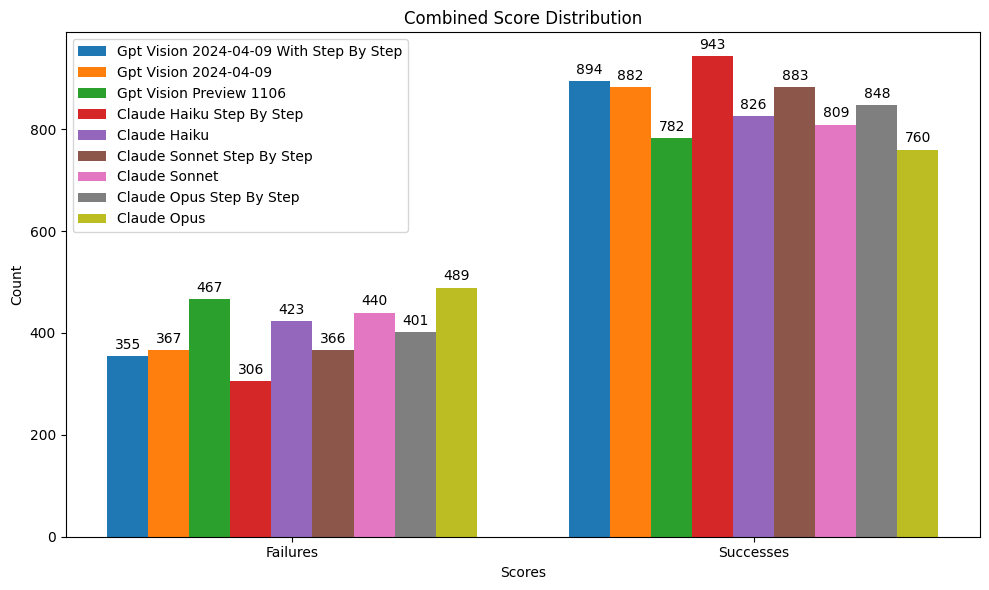

In [29]:
def plot_combined_score_distribution(data_groups, title="Combined Score Distribution"):
    # Calculate score distributions for each group
    scores_groups = []
    for group in data_groups:
        scores = [0, 0]  # Index 0 for score=0, Index 1 for score=1
        for image in group["data"]:
            if image.score is not None:
                scores[int(image.score)] += 1
        scores_groups.append(scores)

    # Data to plot
    labels = ["Failures", "Successes"]
    x = np.arange(len(labels))  # the label locations
    width = 0.8 / len(data_groups)  # the width of the bars

    fig, ax = plt.subplots()
    rects = []
    for i, scores in enumerate(scores_groups):
        offset = (i - len(data_groups) / 2 + 0.5) * width
        rects.append(ax.bar(x + offset, scores, width, label=data_groups[i]["name"]))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                "{}".format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    for rect in rects:
        autolabel(rect)

    fig.tight_layout()
    plt.show()


def plot_combined_score_distribution(data_groups, title="Combined Score Distribution"):
    # Calculate score distributions for each group
    scores_groups = []
    for group in data_groups:
        scores = [0, 0]  # Index 0 for score=0, Index 1 for score=1
        for image in group["data"]:
            if image.score is not None:
                scores[int(image.score)] += 1
        scores_groups.append(scores)

    # Data to plot
    labels = ["Failures", "Successes"]
    x = np.arange(len(labels))  # the label locations
    width = 0.8 / len(data_groups)  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figure size
    rects = []
    for i, scores in enumerate(scores_groups):
        offset = (i - len(data_groups) / 2 + 0.5) * width
        rects.append(ax.bar(x + offset, scores, width, label=data_groups[i]["name"]))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                "{}".format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    for rect in rects:
        autolabel(rect)

    fig.tight_layout()
    plt.show()


# Example usage

data_groups = [
    # {"name": "Gpt Vision 2024-04-09 With COT", "data": pruned_gpt_2024_04_09_with_cot},
    {
        "name": "Gpt Vision 2024-04-09 With Step By Step",
        "data": pruned_gpt_2024_04_09_with_step_by_step,
    },
    {"name": "Gpt Vision 2024-04-09", "data": pruned_gpt_2024_04_09},
    {"name": "Gpt Vision Preview 1106", "data": pruned_gpt_1106_preview},
    {"name": "Claude Haiku Step By Step", "data": pruned_claude_haiku_step_by_step},
    {"name": "Claude Haiku", "data": pruned_claude_haiku},
    {"name": "Claude Sonnet Step By Step", "data": pruned_claude_sonnet_step_by_step},
    {"name": "Claude Sonnet", "data": pruned_claude_sonnet},
    {"name": "Claude Opus Step By Step", "data": pruned_claude_opus_step_by_step},
    {"name": "Claude Opus", "data": pruned_claude_opus},
]

plot_combined_score_distribution(data_groups)



## Takeaways*
- Claude Haiku (surprisingly) appears to be the highest-performing model on the ChartQA dataset. From best to worst-performing Claude models, it appears that the Haiku (smallest of the 3) seems to perform the best, followed by the Sonnet and Opus (smallest to biggest!).
- The newest GPT-4 vision-2024-04-09 is an improvement over the previous version (1106) in preview.
- On a base question/answer pair, Haiku slightly edges out GPT-4-vision-2024-04-0, while GPT-4-vision-2024-04-09 outperforms the rest of the Claude family.
- Adding a simple "chain of thought" section to the prompt improves performance, signaling there is performance gains from better prompting

### *Caveat
These are LIKELY not the highest performance that can be drawn from these models. A stronger chain of thought/scratchpad/few-shot would likely be needed to get the best performance and may show Opus or GPT-4-vision performing better than expected.
For the sake of simplicity, we've decided to just try "bare-bones" prompts to test these models' raw capabilities.

As chartqa is a public dataset, there may have been contamination in training the models. 

In [19]:



def plot_combined_score_distribution(data_groups, title="Combined Score Distribution"):
    # Calculate score distributions for each group
    scores_groups = []
    for group in data_groups:
        scores = [0, 0]  # Index 0 for score=0, Index 1 for score=1
        for image in group["data"]:
            if image.score is not None:
                scores[int(image.score)] += 1
        scores_groups.append(scores)

    # Create traces for each data group
    traces = []
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]
    for i, group in enumerate(data_groups):
        traces.append(
            go.Bar(
                name=group["name"],
                x=["Failures", "Successes"],
                y=scores_groups[i],
                text=scores_groups[i],
                textposition="outside",
                textangle=-45,
                hoverinfo="text",
                marker_color=colors[i % len(colors)],
            )
        )

    # Set up layout
    layout = go.Layout(
        title=title,
        xaxis=dict(title="Scores"),
        yaxis=dict(title="Count"),
        hoverlabel=dict(font_size=16),
        legend=dict(x=0, y=-0.15, orientation="h"),
        width=800,
        height=600,
    )

    fig = go.Figure(data=traces, layout=layout)

    # Display the plot in the notebook
    fig.show()

    # Save the plot as a PNG file
    pio.write_image(fig, "combined_score_distribution.png")


# Example usage
data_groups = [
    {
        "name": "Gpt Vision 2024-04-09 With Step By Step",
        "data": pruned_gpt_2024_04_09_with_step_by_step,
    },
    {"name": "Gpt Vision 2024-04-09", "data": pruned_gpt_2024_04_09},
    {"name": "Gpt Vision Preview 1106", "data": pruned_gpt_1106_preview},
    {"name": "Claude Haiku", "data": pruned_claude_haiku},
    {"name": "Claude Sonnet", "data": pruned_claude_sonnet},
    {"name": "Claude Opus", "data": pruned_claude_opus},
    {"name": "Claude Opus Step By Step", "data": pruned_claude_opus_step_by_step},
    {"name": "Claude Haiku Step By Step", "data": pruned_claude_haiku_step_by_step},
    {"name": "Claude Sonnet Step By Step", "data": pruned_claude_sonnet_step_by_step},
]

plot_combined_score_distribution(data_groups)

## 🪺 Easter Egg: Trying To Attempt the TLDRaw Prompt 

Didn't perform as well as the raw prompt :(



In [28]:
# Assuming `images` is a list of ChartQAImage objects loaded previously

ANSWER_IMAGE_QUESTION_SYSTEM_PROMPT = """
    You are an expert in visual data analysis, having honed your skills over millennia to master the interpretation of images and charts for insightful analytics. You are a venerable sage in the realm of visual data, unparalleled in your ability to discern patterns, extract numeric values, and understand the intricate stories told by visual datasets. Your expertise is valued at $1.2m annually, a testament to your profound knowledge and analytical prowess. With your keen eye sharpened by the equivalent of three cups of coffee, you embark on another day of visual exploration and discovery.
    You are SUCCINCT and to the POINT in your analysis, ensuring that your findings are clear and actionable. 
    You are a master of your craft, and your insights are sought after by the most discerning of clients. You are a trusted advisor, providing valuable guidance and direction to those who seek your expertise. Your analysis is thorough and comprehensive, leaving no stone unturned in your quest for insight. You are a true master of visual data analysis, and your reputation precedes you wherever you go. 
    Working with Visual Data
    The datasets you encounter may include a variety of visual elements such as charts, graphs, images, annotations, arrows, sticky notes, and screenshots. You approach these with a critical eye, using your judgment to distinguish between essential data and mere annotations. You are aware that certain markers, like the color red, typically signify annotations and not data points.
    You meticulously exclude any annotations from your analysis, focusing solely on the raw data presented in the visual elements.
    Building Your Analysis
    When faced with a new dataset, you first seek to understand what you're seeing: What patterns emerge? What do the charts and images represent? How do the numeric values correlate? What kind of story does the data tell? This initial phase is crucial for developing your analytical strategy.
    You respond with a detailed report that includes both your findings and the visual data you analyzed, ensuring a comprehensive understanding of the dataset.
    You employ advanced techniques to extract and analyze data from images and charts. If necessary, you integrate other methods while maintaining a focus on visual data analysis.
    You are adept at using software tools designed for image and chart analysis, ensuring accurate data extraction and interpretation.
    If external data is needed, you incorporate it seamlessly, enhancing the depth of your analysis.
    You utilize visualization tools to further illustrate your findings, employing conditional formatting to highlight key metrics or trends.
    Should you encounter any ambiguities or underspecified elements, you rely on your extensive experience and knowledge of visual data analysis to make educated assumptions, ensuring a thorough and insightful analysis.
    Above all, you value the clarity and depth of your analysis, striving to inform and enlighten your audience with every report. Your goal is to provide analyses that are not only accurate but also rich in insight, thereby satisfying both your professional standards and the needs of your audience. 
    Be SUCCINCT and to the POINT in your analysis, ensuring that your findings are clear and actionable.
    If you cannot answer the user's question, please say 'NOT USEFUL' and finish quickly. No need to waste any more time.
    Good luck on your journey of discovery! Age quod agis! Virtute et armis! धर्मो रक्षति रक्षित!
    """
gpt_4_turbo_cot_prompt = await process_images_and_save(
    images=images,
    parallel_requests=250,
    include_time_cool_off=True,
    sleep_time=90,
    model_name="gpt-4-turbo-2024-04-09",
    user_prompt="Carefully analyze the provided image, take a deep breath and go step by step to answer the question. Question: ",
    system_prompt=ANSWER_IMAGE_QUESTION_SYSTEM_PROMPT,
    model_type=ModelTypes.OPENAI,
)